# Gemini Workshop: The Hands-On Lab Session

During This Session:

- You will learn a little bit about Jupyter, a web-based programming environment.
- You will learn a little Python, a popular programming language.
- You will explore an RF signal dataset.
- You will learn about hamming fingerprints.
- You will use Gemini to search a RF signal dataset where each signal is represented by a hamming fingerprint.
- You will use search results to classify unknown RF signals using a technique called KNN

To help solidify your understanding, you will be presented with exercises along the way.  OK, Let's Get Started !
***

# What Is Jupyter?

* Jupyter is the web-based programming environment that you are in right now.  
* A Jupyter "notebook" is composed of a bunch of "cells" stacked on top of each other.  
* Some cells are for documentation (like this one.) 
* Some cells are for Python code.
* Some cells show the output of code cells.  
* This will become more obvious as we proceed through this notebook.
***

# Exercise 1

Now for your first exercise:  
* The cell right below this one contains some code.  Click once in the code cell.  This will make the cell active ( notice the blue outline. )  
* Locate the "play" button in the toolbar at the top of the notebook.  You should see an image appear right below the code.
***

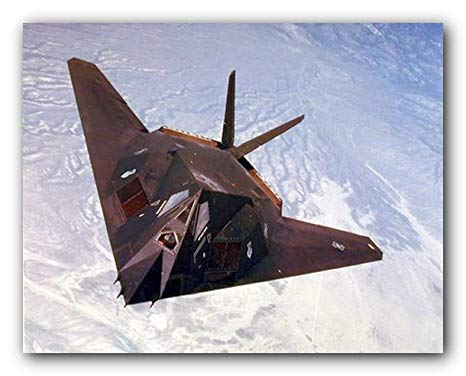

In [1]:
from IPython.display import Image
Image("asurprise.jpg") 

# What Is Python?

Congratulations.  If you got the image to appear, you successfully ran python code in this Jupyter notebook!  Python is a popular programming language and we will use it throughout this session.

***

# Exercise 2

* The cell right below this one contains some code.  Run it and you will notice it will print a random number right below it.
* Trying running it several times.  Notice it will display a different random number each time.  ( Note that you will need to click on the code cell to reselect it.  That's because Jupyter automatically hops to the next cell after execution. )

***

In [3]:
import random
print( random.random() )

0.5035190537535459


***
# Radio Frequency Signal Classification

Alright, let's start to dig into the application we are showcasing in this session - RF Signal Classification.  This is an important application in government and aerospace for signal monitoring and spectrum management.

We will be using Gemini to help us classify unknown radio frequency (RF) signals.
***

# Exercise 3

* The cell right below this one contains some code to load an RF signal database.  Run it and you should notice a message indicating success right below the code cell.

***

In [1]:
import rf_signals
rf_signals.load()

Using radioml dataset directory at ../../../signal
Loading fingerprints...
Loading raw signals...
Loading signal labels...
Loading signal-to-noise values...
The RF signal database loaded successfully.  There are 100000 total signals.


***

# Exercise 4

* The next cell's code will choose at random some of the signals and display them.  Feel free to run it several times.
* The database has several types of signals with names like '64APSK', 'AM-SSB-WC', '32PSK', etc., and there are many examples of each in the database.  

***

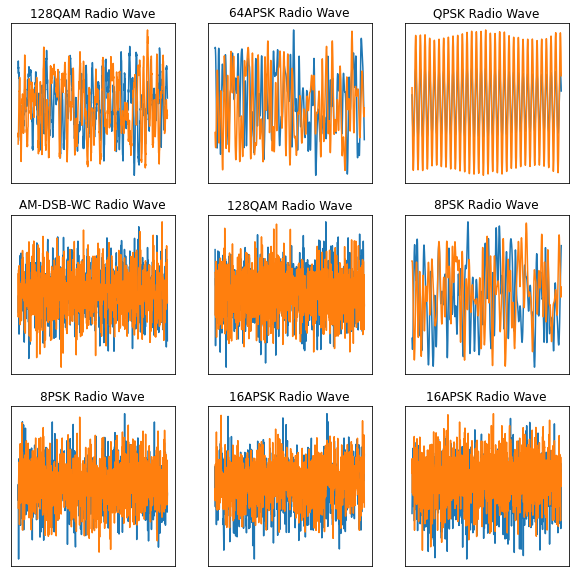

In [2]:
rf_signals.randisplay()

***
# Exercise 5

* Now let's load a different dataset of signals.  In this database, the signals haven't yet been classified.  
* Go ahead and run the next code cell to load the database of unknown signals.

***

In [3]:
import unknown_signals
unknown_signals.load()

Using rf signal dataset directory at ../../../signal
Loading fingerprints...
Loading raw signals...
Loading signal-to-noise values...
The RF signal database loaded successfully.  There are 50 total signals.


***

# Exercise 6

* The next cell's code will choose at random some of the signals and display them.  Feel free to run it several times.
* Remember, the signals in this database have not been classified yet!  That's why you see a question mark in the subplot titles.

***

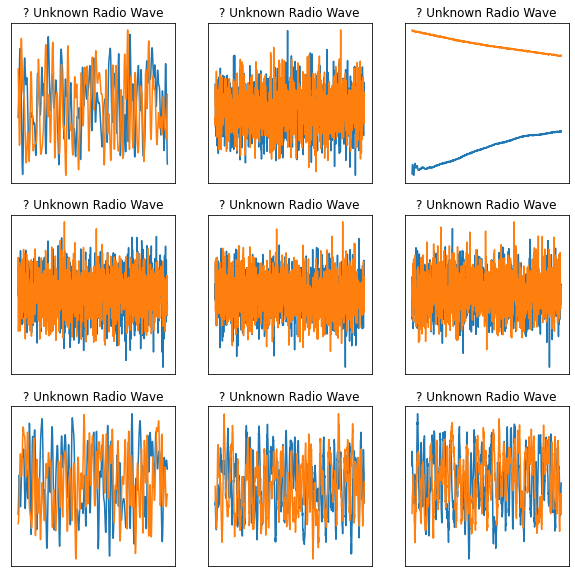

In [4]:
unknown_signals.randisplay()

***

# Exercise 7

Now you will use Gemini similarity search in order to help classify the unknown signals.  

First, let's now import the dataset.  Go ahead and run the next code cell.

***

In [5]:
import swagger_client
from swagger_client.models import *
from swagger_client.rest import ApiException
import sys

# Configuration
configuration = swagger_client.configuration.Configuration()
configuration.verify_ssl = False
configuration.host = "http://localhost:7761/v1.0"
api_config = swagger_client.ApiClient(configuration)

# Get handls to various GSI library objects
gsi_boards_apis = swagger_client.BoardsApi(api_config)
gsi_datasets_apis = swagger_client.DatasetsApi(api_config)
gsi_search_apis = swagger_client.SearchApi(api_config)

# Set this to None or a valid dataset id 
dataset_id = "14f34d04-71a7-11eb-aa48-0242ac110002"

if not dataset_id:
    try:

        # Import Dataset
        print("OK, about to import the dataset. This may take a while...")
        response = gsi_datasets_apis.apis_import_dataset(body=ImportDatasetRequest(rf_signals.path, train_ind=True))
        dataset_id = response.dataset_id
        print("Import done!")

    except ApiException as e:
        print(e.status)
        print(e.body)
        print(e.reason)
        raise e
        
else:
    print("Using a dataset already loaded with dataset_id = ", dataset_id )

Using a dataset already loaded with dataset_id =  14f34d04-71a7-11eb-aa48-0242ac110002


***

# Exercise 8

Now, let's perform the hamming search.  Go ahead and run the next code cell.

***

In [7]:
import swagger_client
from swagger_client.models import *
from swagger_client.rest import ApiException
import sys

try:

    print("Using dataset with dataset_id = ", dataset_id)  

    # Allocate Board/s
    num_of_boards = 1
    print("Allocating the %d board(s)..." % num_of_boards)
    response = gsi_boards_apis.apis_allocate(body=AllocateRequest(num_of_boards))
    allocation_id = response.allocation_id
    print("Allocation done!")

    # Load Dataset That Has Already Been Imported
    print("Loading the dataset into the APU")
    gsi_datasets_apis.apis_load_dataset(body=LoadDatasetRequest(allocation_id, dataset_id, topk=5))
    print("Load done!")

    # Search
    print("Performing the searching...")
    search_api_response = gsi_search_apis.apis_search(body=SearchRequest(allocation_id, dataset_id, 
                                                                         queries_path=unknown_signals.path))
    indices = search_api_response.indices
    print("Search done!")

except ApiException as e:
    print(e.status)
    print(e.body)
    print(e.reason)
    raise e


Using dataset with dataset_id =  14f34d04-71a7-11eb-aa48-0242ac110002
Allocating the 1 board(s)...
Allocation done!
Loading the dataset into the APU
Load done!
Performing the searching...
Search done!


***

# Exercise 9

Now, before we use the results for signal classification.  Let's go ahead and release the resources.

Go ahead and run the next cell.

***

In [8]:

# Deallocate Board/s
if allocation_id is not None:
    gsi_boards_apis.apis_deallocate(body=DeallocateRequest(allocation_id))
    allocation_id = None

# Unload Dataset
# gsi_datasets_apis.apis_unload_dataset(body=UnloadDatasetRequest(allocation_id, dataset_id))
    
print("Done.")

Done.


***

# Exercise 10

Now, lets use those similarity search predictions.  Run the code below.  

It will randomly choose three of the unknown signals (top row).  Directly below each unknown are the top 5 matches from similarity search.  

We can now use a majority vote of the top-K matches (K=5 in this case) in order to classify the unknown signal.  This is called KNN classification.

***

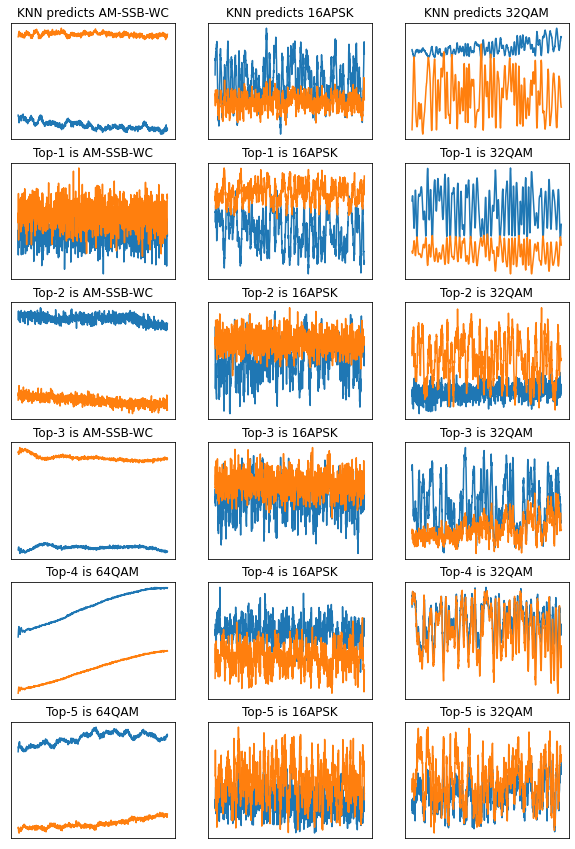

In [9]:
import knn
predictions = knn.classify( rf_signals, unknown_signals, indices )
knn.randisplay( predictions, rf_signals, unknown_signals )